# 2 Dimensionality reduction and clustering

Here, we will use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany.

In [1]:
# import all libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from utils import dataset_treatment

Let's start by loading the data

In [50]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias, customers = dataset_treatment(azdias, customers)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Deleting columns...
Deleting rows...
Encoding...


### Dimensionality reduction
As the number of features in the data is relatively high, our first step will be to reduce the number of features while keeping as much variance as possible. By using a dimensionality reduction technique, we can effectively reduce the number of features which do not vary much in the data. Since we cannot go through each and every feature ourselves to decide if the feature is varying, we can use a statistical approach to find how much variance is explained by each feature. One such algorithm is Principal Component Analysis(PCA).

In [3]:
def perform_pca(data, n_components=None):
    pca = PCA(n_components)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [4]:
pca_azdias, _ = perform_pca(azdias)

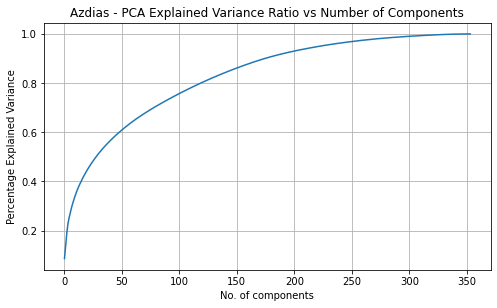

In [5]:
# Let's explore the variance of the components

azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
y_label = "Percentage Explained Variance"

fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(211)
ax.plot(azdias_variance)
ax.set_xlabel("No. of components")
ax.set_ylabel(y_label)
ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
ax.grid()
plt.show()

As we can see, we can get rid of half the features and still retain 90% of the variance. Let's do that!

In [6]:
pca_175, azdias_pca_175 = perform_pca(azdias, n_components=175)

### Interpreting the selected components 
We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. The following code shows the feature-level makeup of the first component.

In [30]:
def plot_feature_weights(features, components, dimension, n_weights = 3, figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
    
    component_info = {"Feature":feat_names, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    
    fig = plt.figure(figsize=(7,8))

    ax = fig.add_subplot(211)
    ax.bar(feat_names, feat_weights)
    ax.set_ylabel("Feature Weight")
    ax.set_xlabel("Feature Name")
    ax.set_title("PCA Feature weights - Component {}".format(dimension+1))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    ax.grid()

    fig.tight_layout()
    plt.show()
    
    return component_info

Let's now inspect the make up of the top 3 components, and refer to the attributes_info file to know what it represent (when the description is available).

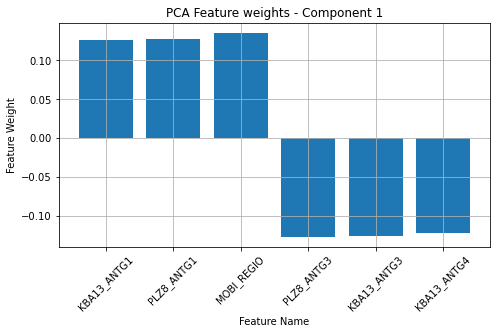

,Feature,FeatureWeight
0,MOBI_REGIO,0.135047
1,PLZ8_ANTG1,0.127500
2,KBA13_ANTG1,0.126900
3,KBA13_ANTG4,-0.121975
4,KBA13_ANTG3,-0.125836
5,PLZ8_ANTG3,-0.126473


In [31]:
# display makeup of first component
component_1_info = plot_feature_weights(azdias.columns.values, pca_175.components_, dimension=0)
component_1_info.head(6)

Component 1:

- Has a high positive weight to moving patterns (MOBI_REGIO).
- Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses (respectively PLZ8_ANTG1 and PLZ8_ANTG3).

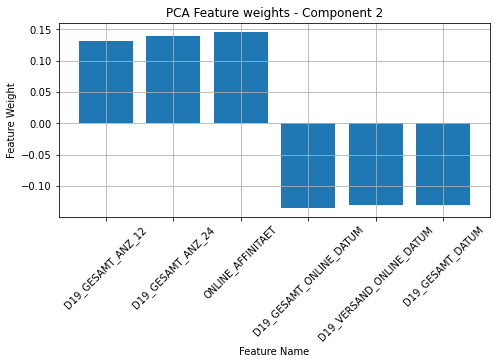

,Feature,FeatureWeight
0,ONLINE_AFFINITAET,0.146148
1,D19_GESAMT_ANZ_24,0.139879
2,D19_GESAMT_ANZ_12,0.132048
3,D19_GESAMT_DATUM,-0.129720
4,D19_VERSAND_ONLINE_DATUM,-0.130386
5,D19_GESAMT_ONLINE_DATUM,-0.135229


In [32]:
# display makeup of second component
component_2_info = plot_feature_weights(azdias.columns.values, pca_175.components_, dimension=1)
component_2_info.head(6)

Component 2:

- Has a high positive weights towards online activity (ONLINE_AFFINITAET).

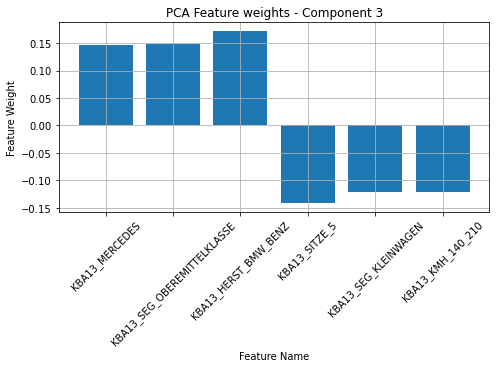

,Feature,FeatureWeight
0,KBA13_HERST_BMW_BENZ,0.172169
1,KBA13_SEG_OBEREMITTELKLASSE,0.149261
2,KBA13_MERCEDES,0.146296
3,KBA13_KMH_140_210,-0.121020
4,KBA13_SEG_KLEINWAGEN,-0.121818
5,KBA13_SITZE_5,-0.141463


In [33]:
# display makeup of third component
component_3_info = plot_feature_weights(azdias.columns.values, pca_175.components_, dimension=2)
component_3_info.head(6)

Component 3:

- Has a high positive weights towards the share of BMW & MERCEDES (KBA13_HERST_BMW_BENZ).
- Has a negative weight to features that have information about lower class cars's share (KBA13_SEG_KLEINWAGEN).

Those features might be correlated to one's financial situation

### K-Means Clustering
Now, we’ll use the unsupervised clustering algorithm, k-means, to segment our population using their PCA attributes. K-means is a clustering algorithm that identifies clusters of similar data points based on their component makeup.

**Choosing a "Good" K**  
One method for choosing a "good" k, is to choose based on empirical data. A bad k would be one so high that only one or two very close data points are near it, and another bad k would be one so low that data points are really far away from the centers.

We want to select a k such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. We can approximate this separation by measuring how close your data points are to each cluster center; the average centroid distance between cluster points and a centroid. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k.  Let's try the algorithm for different numbers of clusters (k). 

In [24]:
def get_Kmeans_scores(data, K_max):
    
    scores = []
    data = pd.DataFrame(data)
    print("Performing K-Means clustering")

    for n in range(2, K_max):
        
        print("\nTraining for {} clusters: ".format(n))
        start = time.time()
        
        kmeans = KMeans(n)
        model = kmeans.fit(data.sample(20000)) # To save time, let's just work with a sample of the dataset
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(2, K_max)

In [25]:
scores, range_ = get_Kmeans_scores(azdias_pca_175, 15)

Performing K-Means clustering

Training for 2 clusters: 
Done! Score:  218655469.56816486
Time elapsed: 1.43 sec.

Training for 3 clusters: 
Done! Score:  210874392.75010875
Time elapsed: 2.01 sec.

Training for 4 clusters: 
Done! Score:  206532995.20222083
Time elapsed: 2.95 sec.

Training for 5 clusters: 
Done! Score:  202906752.71982738
Time elapsed: 3.10 sec.

Training for 6 clusters: 
Done! Score:  199982946.33117038
Time elapsed: 4.16 sec.

Training for 7 clusters: 
Done! Score:  197588197.94790012
Time elapsed: 5.09 sec.

Training for 8 clusters: 
Done! Score:  195479678.61189356
Time elapsed: 4.76 sec.

Training for 9 clusters: 
Done! Score:  193708689.19320178
Time elapsed: 6.06 sec.

Training for 10 clusters: 
Done! Score:  192392238.014568
Time elapsed: 5.12 sec.

Training for 11 clusters: 
Done! Score:  191274106.76608026
Time elapsed: 7.07 sec.

Training for 12 clusters: 
Done! Score:  190071338.24246457
Time elapsed: 5.56 sec.

Training for 13 clusters: 
Done! Score:  189

The graph below indicates the average centroid distance for value of k between 2 and 15

In [26]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

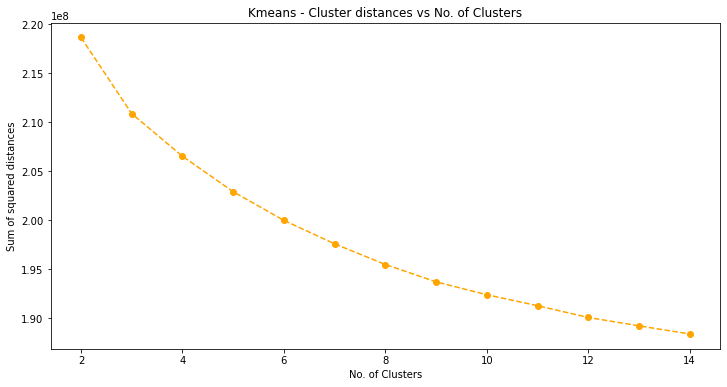

In [27]:
plot_elbow(scores, range_)

Unfortunatly, there is no obvious "elbow". However, we could say that after 8, the sum of squared distances decrease very slowly. This indicates that there is enough separation to distinguish the data points in each cluster, but also that we included enough clusters so that the data points aren’t extremely far away from each cluster.  
Let's recreate our kmeans model with 8 clusters and transform both datasets.

In [35]:
kmeans = KMeans(8)
kmeans.fit(azdias_pca_175)

KMeans()

In [36]:
# Transform the azdias dataset
azdias_clusters = kmeans.predict(azdias_pca_175)

# Transform the customers dataset
customers_pca_175 = pca_175.transform(customers)
customers_clusters = kmeans.predict(customers_pca_175)

In [38]:
# Let's free up some space:
azdias = None
customers = None

Now, let's compare how each population (general vs customers) is distributed within those clusters.

In [39]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [40]:
# Merge cluster data

cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)
cluster_info

,Cluster,Population,Customers
0,0,65473,4482
1,1,96312,16115
2,2,68979,3319
3,3,69896,29690
4,4,89889,2247
5,5,116153,38960
6,6,117725,38176
7,7,112861,1257


In [41]:
# Add proportion information
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

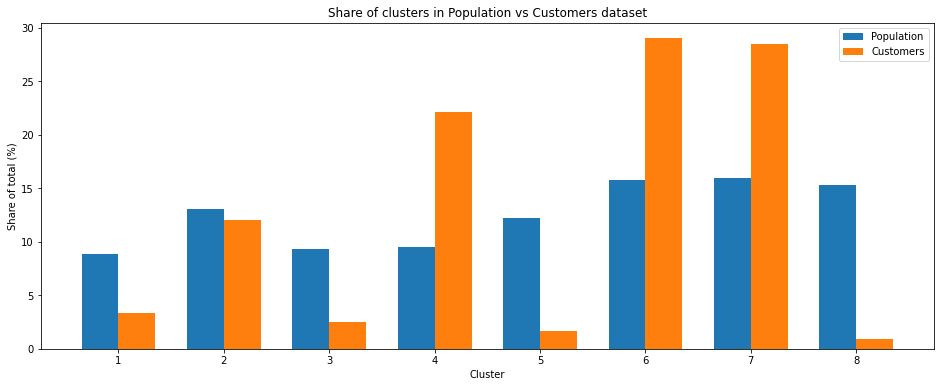

In [45]:
# Plot clusters 
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(8)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, cluster_info["Pop_proportion"], width, bottom=0)
p2 = ax.bar(ind + width, cluster_info["Cust_proportion"], width, bottom=0)

ax.set_title('Share of clusters in Population vs Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([1,2,3,4,5,6,7,8])
ax.legend((p1[0], p2[0]), ('Population', 'Customers'))
ax.autoscale_view()

The plot shows how clusters are distributed across both datasets. Clusters are equally spread across the general population and show only small differences in size. This can be expected from dataset that represents the general population very well.

In contrast, the customers dataset has a large imbalance across clusters. Cluster 4, 6 and 7 stand out specifically: ~75% of customers are mapped within those 3 clusters.

### Cluster makeup
Now that we know into wich clusters the customers tend to fall into, let's try to understand what they represent.   
Let's see which pca component influences a given cluster most.

In [54]:
kmeans_model_params = kmeans.cluster_centers_
print(kmeans_model_params.shape)

(8, 175)


### Cluster 4

In [62]:
centroid_4 = pd.Series(kmeans_model_params[3])
centroid_4.sort_values(ascending=False, inplace=True, ignore_index=False)
centroid_4

2     5.732256
0     1.706421
3     1.569234
4     1.314766
6     0.730275
        ...   
16   -0.221651
27   -0.274496
8    -0.651524
11   -0.664646
1    -4.224392
Length: 175, dtype: float64

This cluster is higly correlated to component 3 and higly negatively correlated to component 2.   
Using the interpretation we made earlier of the principal components, we could say that this cluster:
- Has a high positive weights towards the share of BMW & MERCEDES (KBA13_HERST_BMW_BENZ).
- Has a negative weight to features that have information about lower class cars's share (KBA13_SEG_KLEINWAGEN).
- Has a high **negative** weight towards online activity (ONLINE_AFFINITAET). 

### Cluster 6

In [65]:
centroid_6 = pd.Series(kmeans_model_params[5])
centroid_6.sort_values(ascending=False, inplace=True, ignore_index=False)
centroid_6

0     3.601203
11    0.400636
5     0.295437
35    0.195938
25    0.159088
        ...   
6    -0.369296
9    -0.429048
4    -0.574269
2    -2.860756
1    -4.152590
Length: 175, dtype: float64

This cluster is higly correlated to component 1 and higly negatively correlated to component 2.   
Using the interpretation we made earlier of the principal components, we could say that this cluster:
- Has a high positive weight to moving patterns (MOBI_REGIO).
- Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses (respectively PLZ8_ANTG1 and PLZ8_ANTG3).
- Has a high **negative** weight towards online activity (ONLINE_AFFINITAET). 

### Cluster 7

In [66]:
centroid_7 = pd.Series(kmeans_model_params[6])
centroid_7.sort_values(ascending=False, inplace=True, ignore_index=False)
centroid_7

0     7.793665
1     3.339253
3     0.755275
30    0.188343
2     0.185833
        ...   
6    -0.239672
10   -0.283906
35   -0.296696
9    -0.308310
4    -0.350785
Length: 175, dtype: float64

This cluster is higly correlated to component 1.   
Using the interpretation we made earlier of the principal components, we could say that this cluster:
- Has a high positive weight to moving patterns (MOBI_REGIO).
- Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses (respectively PLZ8_ANTG1 and PLZ8_ANTG3).


### Little summary
As a summary, features which seems to defined whether an individual could be a customer are:
- Moving patterns - MOBI_REGIO (positively correlated).
- The share of BMW & MERCEDES - KBA13_HERST_BMW_BENZ (positively correlated).
- Online activity - ONLINE_AFFINITAET (negatively correlated).

A deeper analyse could help understand in details what kind of people constitute each cluster. This would help understand the existing customers and their behaviour according to demographics data.

However, that information won't be useful in the creation and training of a prediction model. 
